In [6]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path, makedirs

In [47]:
def plot_table(df, title, save_path, filename):
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, colColours=['peachpuff'] * len(df.columns), rowColours=['peachpuff'] * len(df.index), loc='center')
    table.auto_set_column_width(list(range(len(df.columns))))
    
    #table.auto_set_font_size(False)
    #table.set_fontsize(12)
    #table.scale(1.5, 1.5)
    table.scale(1, 2)
    
    fig.suptitle(title)
    fig.tight_layout()
    plt.savefig(path.join(save_path, filename),bbox_inches='tight', dpi=300)
    plt.show()

def average_results(datasets_results_dict, save_path, filename):
    results_average = {}
    metrics = ['AUCperf', 'Corr', 'AvgMM', 'AUChsp', 'NSShsp', 'IGhsp', 'LLhsp']
    number_of_datasets = len(datasets_results_dict)
    for dataset in datasets_results_dict:
        dataset_res   = datasets_results_dict[dataset]

        for model in dataset_res:
            if not model in results_average:
                results_average[model] = {}

            for metric in metrics:
                if metric in dataset_res[model]:
                    if metric in results_average[model]:
                        results_average[model][metric] += dataset_res[model][metric] / number_of_datasets
                    else:
                        results_average[model][metric] = dataset_res[model][metric] / number_of_datasets
    
    final_table = create_table(results_average)
    save_to_json(path.join(save_path, filename), results_average)
    final_table.to_csv(path.join(save_path, filename + '.csv'))
    
    return final_table

def create_df(dict_):
    return pd.DataFrame.from_dict(dict_)

def create_dirs(filepath):
    dir_ = path.dirname(filepath)
    if len(dir_) > 0 and not path.exists(dir_):
        makedirs(dir_)  

def save_to_json(filepath, data):
    create_dirs(filepath)

    with open(filepath, 'w') as json_file:
        json.dump(data, json_file, indent=4)

def create_table(results_dict):
    add_score(results_dict)
    table = create_df(results_dict).T
    # Move Score to the last position
    table = table[[metric for metric in table if metric != 'Score'] + ['Score']]

    return table.sort_values(by=['Score'], ascending=False)

def add_score(results_dict):
    # For each metric, different models are used as reference values
    reference_models = {'AUCperf': 'Humans', 'AvgMM': 'Humans', \
        'AUChsp': 'gold_standard', 'NSShsp': 'gold_standard', 'IGhsp': 'gold_standard', 'LLhsp': 'gold_standard'}

    # Only the average across dimensions is used for computing the score
    excluded_metrics = ['MMvec', 'MMdir', 'MMpos', 'MMlen']
    
    for model in results_dict:
        score = 0.0
        number_of_metrics = 0

        metrics_values = results_dict[model]
        valid_metrics  = [metric_name for metric_name in metrics_values if metric_name not in excluded_metrics]
        for metric in valid_metrics:
            if not metric in reference_models:
                score += metrics_values[metric]
            else:    
                reference_value = results_dict[reference_models[metric]][metric]
                if metric == 'AUCperf':
                    # AUCperf is expressed as 1 subtracted the absolute difference between Human and model's AUCperf, maximizing the score of those models who were closest to human subjects
                    score += 1 - abs(reference_value - metrics_values[metric])
                else:
                    score += (metrics_values[metric] - reference_value) / reference_value
            metrics_values[metric] = np.round(metrics_values[metric], 3)
            number_of_metrics += 1
        results_dict[model]['Score'] = np.round(score / number_of_metrics, 3)



In [48]:
with open('Scores.json') as f:
    scores = json.load(f)

df = create_table(scores)

In [49]:
df.loc['eccNET',['AUChsp', 'NSShsp', 'IGhsp', 'LLhsp', 'Score']] = np.nan

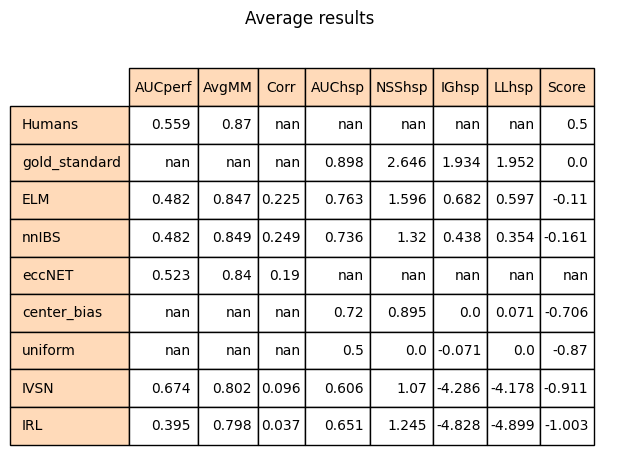

In [50]:
plot_table(df, 'Average results', '.', 'Average_results.png')